# Практика по PyTorch

#### Импорты

In [1]:
# preload local libs
import sys
import os
import pathlib

project_dir = str(pathlib.Path(os.getcwd()).parent.resolve())
if project_dir not in sys.path:
    sys.path.insert(1, project_dir)

# project_dir

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms
from torchvision.transforms import functional as TF
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split
from torch import Tensor

import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from itertools import product

NUM_WORKERS = 8
BATCH_SIZE = 128
#DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE = 'cpu'

#### Функции

In [3]:
def target_func(x: Tensor, y: Tensor) -> Tensor:
    return torch.sin(x + 2 * y) * torch.exp(-(2 * x + y)**2)

def target_func_np(x, y):
    return np.sin(x + 2 * y) * np.exp(-(2 * x + y) ** 2)

#### Визуализация функции

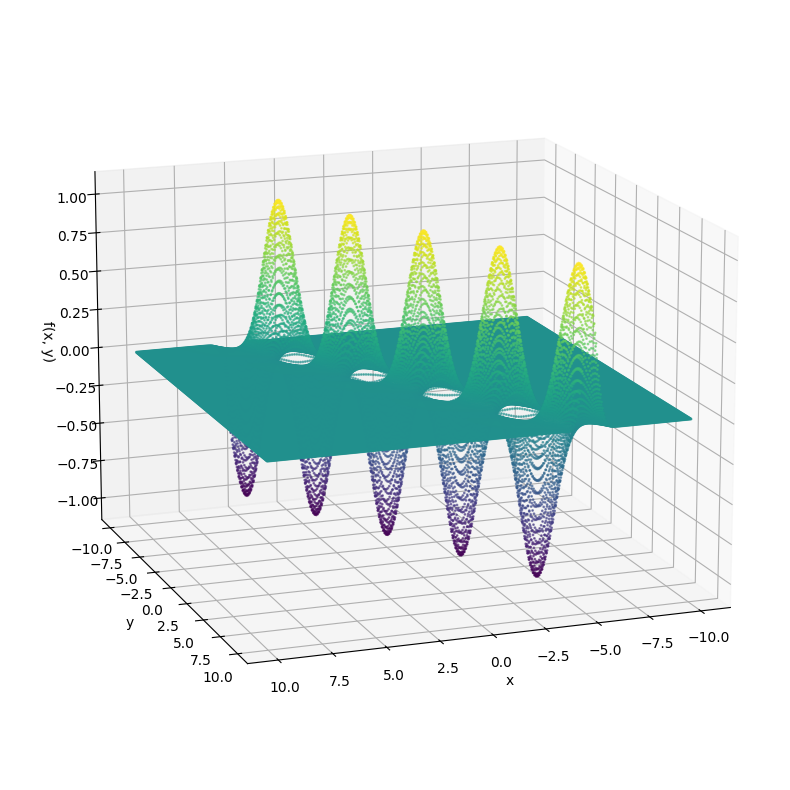

In [53]:
x = np.arange(-10, 10, 0.05)
y = np.arange(-10, 10, 0.05)
X, Y = np.meshgrid(x, y)
Z = target_func_np(X, Y)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
ax.scatter(X, Y, Z, c = Z, s=1, alpha=0.6)
ax.view_init(elev=15, azim=70)
plt.tight_layout()
plt.show()

#### Генерация данных

In [5]:
N = 20000
# случайные точки в заданном диапазоне (равномерное распределение)
x = -10 + 20 * torch.rand(N, 1)
y = -10 + 20 * torch.rand(N, 1)

X = torch.cat([x, y], dim=1)
z = target_func(x, y)

Разделить получившийся датасет на train / test / val в отношениях 70% / 15% / 15%, соответственно.

In [6]:
dataset = TensorDataset(X, z)

train_size = int(0.7 * N)
val_size   = int(0.15 * N)
test_size  = N - train_size - val_size

train_ds, val_ds, test_ds = random_split(
    dataset, [train_size, val_size, test_size]
)

X_train, y_train = train_ds[:]
X_val, y_val = val_ds[:]
X_test, y_test = test_ds[:]

#### Нормализация

In [7]:
def normalize(data: Tensor) -> Tensor:
    """Нормализация с нулевым матожиданием (симметрично ноля)"""
    mean = X_train.mean(dim=0)
    std  = X_train.std(dim=0)
    return (data - mean) / std

In [8]:
# Нормализуем только параметры, целевое значение остается как есть.
train_ds = TensorDataset(normalize(X_train), y_train)
val_ds   = TensorDataset(normalize(X_val), y_val)
test_ds  = TensorDataset(normalize(X_test), y_test)

In [9]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

#### Модель, которая аппроксимирует значение функции 

In [10]:
# Простая полносвязная сеть с гиперпараметром размерности
class RegressionNet(nn.Module):
    def __init__(self, _hidden_dim, _hidden_layers):
        super().__init__()

        layers = []
        # Входной слой
        layers.append(nn.Linear(2, _hidden_dim))
        layers.append(nn.ReLU())

        # Добавляем промежуточные скрытые слои
        for _ in range(_hidden_layers):
            layers.append(nn.Linear(_hidden_dim, _hidden_dim))
            layers.append(nn.ReLU())

        # Выходной слой
        layers.append(nn.Linear(_hidden_dim, 1))

        self.net = nn.Sequential(*layers)        
    
    def forward(self, x):
        return self.net(x)

In [11]:
def train_model(
        _model,
        _optimizer,
        _criterion,
        _train_loader,
        _val_loader,
        _epochs=1
    ):
    # Обучение
    _model.train()
    for epoch in tqdm(range(_epochs)):
        train_loss = 0.0
        for X_b, y_b in _train_loader:
            _optimizer.zero_grad()
            pred = _model(X_b)
            loss = _criterion(pred, y_b)
            loss.backward()
            _optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(_train_loader)

        #if (epoch+1) % 5 == 0:
        #    print(f"Эпоха [{epoch+1}/{_epochs}], MSE Mean: {train_loss:.6f}")
    
    # Валидация
    _model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_b, y_b in _val_loader:
            preds = _model(X_b)
            loss = nn.MSELoss()(preds, y_b) # валидация на фиксированной метрике
            val_loss += loss.item()

    return val_loss / len(_val_loader)

Сетка гиперпараметров

In [12]:
lrs = [1e-3, 3e-4]
hidden_dims = [16, 32, 64]
hidden_layers = [1, 2, 3]

param_grid = list(product(lrs, hidden_dims, hidden_layers))

Простая кросс-валидация. Можно было бы использовать K-Fold, но с ним все сильно дольше будет вычисляться.

In [19]:
results = []

for lr, hidden_dim, hidden_layers in param_grid:
    model = RegressionNet(hidden_dim, hidden_layers)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    # _optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    mean_mse = train_model(model, optimizer, criterion, train_loader, val_loader, 150)

    results.append({
        "lr": lr,
        "hidden_dim": hidden_dim,
        "hidden_layers": hidden_layers,
        "cv_mse": mean_mse
    })

    print(f"lr={lr}, dim={hidden_dim}, layer={hidden_layers}. MSE={mean_mse:.6f}")


100%|██████████| 150/150 [00:42<00:00,  3.55it/s]


lr=0.001, dim=16, layer=1. MSE=0.013379


100%|██████████| 150/150 [00:44<00:00,  3.34it/s]


lr=0.001, dim=16, layer=2. MSE=0.007240


100%|██████████| 150/150 [00:47<00:00,  3.16it/s]


lr=0.001, dim=16, layer=3. MSE=0.000723


100%|██████████| 150/150 [00:42<00:00,  3.54it/s]


lr=0.001, dim=32, layer=1. MSE=0.003044


100%|██████████| 150/150 [00:45<00:00,  3.30it/s]


lr=0.001, dim=32, layer=2. MSE=0.000293


100%|██████████| 150/150 [00:48<00:00,  3.07it/s]


lr=0.001, dim=32, layer=3. MSE=0.000619


100%|██████████| 150/150 [00:43<00:00,  3.44it/s]


lr=0.001, dim=64, layer=1. MSE=0.000602


100%|██████████| 150/150 [00:47<00:00,  3.14it/s]


lr=0.001, dim=64, layer=2. MSE=0.000331


100%|██████████| 150/150 [00:52<00:00,  2.88it/s]


lr=0.001, dim=64, layer=3. MSE=0.000152


100%|██████████| 150/150 [00:41<00:00,  3.57it/s]


lr=0.0003, dim=16, layer=1. MSE=0.012605


100%|██████████| 150/150 [00:45<00:00,  3.27it/s]


lr=0.0003, dim=16, layer=2. MSE=0.011265


100%|██████████| 150/150 [00:47<00:00,  3.17it/s]


lr=0.0003, dim=16, layer=3. MSE=0.004239


100%|██████████| 150/150 [00:42<00:00,  3.53it/s]


lr=0.0003, dim=32, layer=1. MSE=0.010572


100%|██████████| 150/150 [00:45<00:00,  3.31it/s]


lr=0.0003, dim=32, layer=2. MSE=0.002129


100%|██████████| 150/150 [00:48<00:00,  3.06it/s]


lr=0.0003, dim=32, layer=3. MSE=0.000721


100%|██████████| 150/150 [00:43<00:00,  3.45it/s]


lr=0.0003, dim=64, layer=1. MSE=0.006346


100%|██████████| 150/150 [00:47<00:00,  3.16it/s]


lr=0.0003, dim=64, layer=2. MSE=0.000215


100%|██████████| 150/150 [00:51<00:00,  2.89it/s]


lr=0.0003, dim=64, layer=3. MSE=0.000114


In [20]:
best = min(results, key=lambda x: x["cv_mse"])

print("\nBest configuration:")
for k, v in best.items():
    print(f"{k}: {v}")



Best configuration:
lr: 0.0003
hidden_dim: 64
hidden_layers: 3
cv_mse: 0.00011396176720760802


#### Выводы

* `lr: 0.001` - лучше работает на неглубоких сетях, `0.0003` - выигрывает на более глубоких сетях
* `hidden_layers = 2` - значительно лучше одного слоя. Три слоя - еще лучше, но возрастает чувствительность от LR

#### Тестирование

In [22]:
model = RegressionNet(best['hidden_dim'], best['hidden_layers'])
optimizer = torch.optim.AdamW(model.parameters(), lr=best['lr'])
criterion = nn.MSELoss()

train_model(model, optimizer, criterion, train_loader, val_loader, 150)

test_mse = 0.0

model.eval()
with torch.no_grad():
    for X_b, y_b in test_loader:
        preds = model(X_b)
        loss = nn.MSELoss()(preds, y_b)
        test_mse += loss.item()

test_mse /= len(test_loader)

print(f"\nFinal Test MSE: {test_mse:.6f}")

100%|██████████| 150/150 [00:52<00:00,  2.87it/s]



Final Test MSE: 0.000184


#### Визуализация

In [ ]:
# Диапазон
grid_size = 400
x_vals = np.linspace(-10, 10, grid_size)
y_vals = np.linspace(-10, 10, grid_size)

X_grid, Y_grid = np.meshgrid(x_vals, y_vals)

# Z_true = np.sin(X_grid + 2 * Y_grid) * np.exp(-(2 * X_grid + Y_grid) ** 2)
Z_true = target_func_np(X_grid, Y_grid)

# Превращаем сетку в список точек
XY = np.stack([X_grid.ravel(), Y_grid.ravel()], axis=1)
XY_torch = torch.tensor(XY, dtype=torch.float32)

# Нормализация тем же mean/std
mean = X_train.mean(dim=0)
std  = X_train.std(dim=0)

XY_torch = (XY_torch - mean) / std

model.eval()
with torch.no_grad():
    Z_pred = model(XY_torch).cpu().numpy()

Z_pred = Z_pred.reshape(grid_size, grid_size)

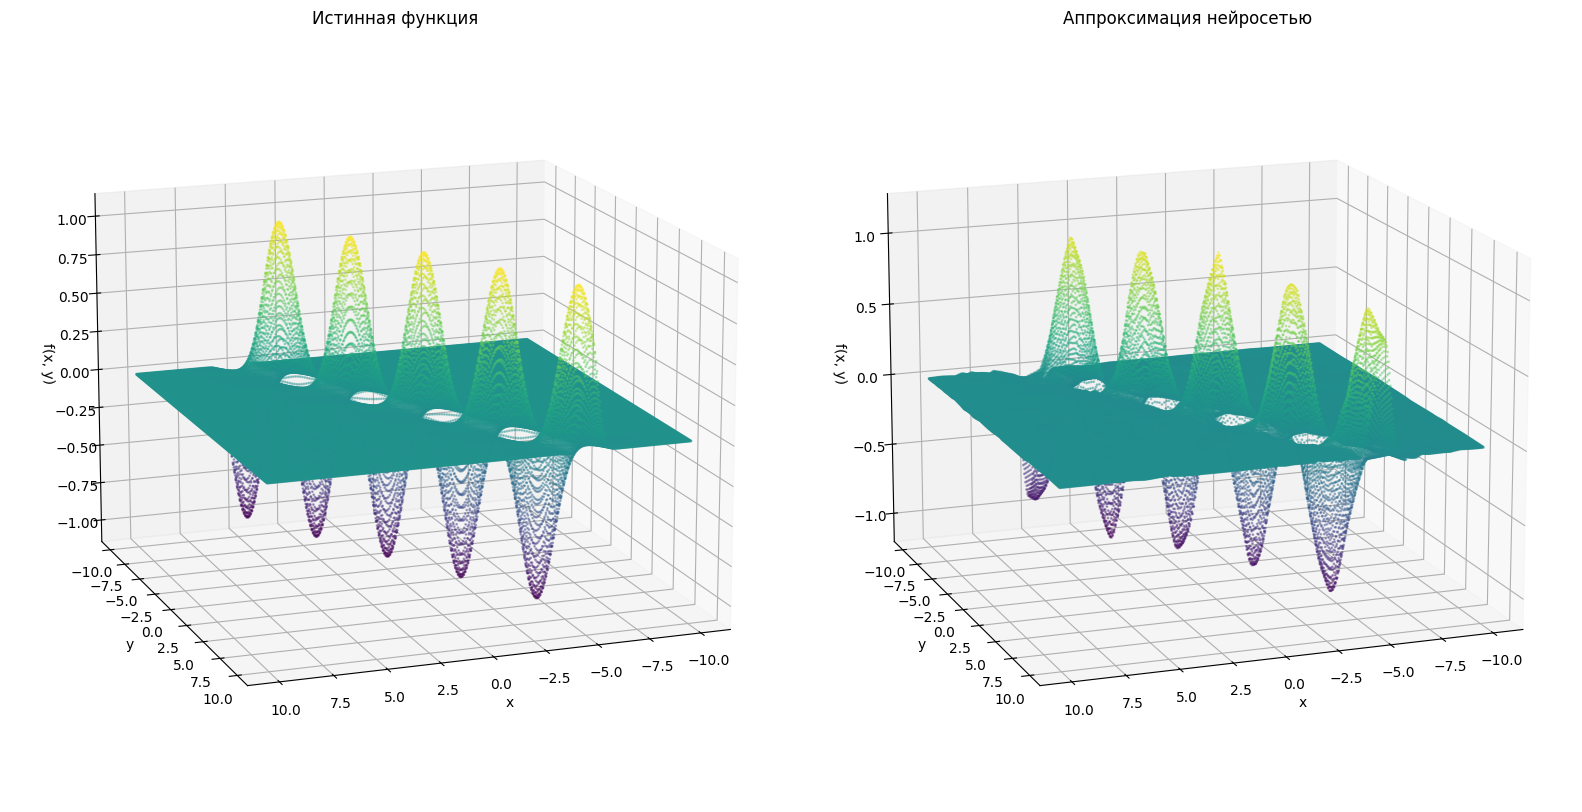

In [47]:
fig = plt.figure(figsize=(16, 8))

ax = fig.add_subplot(121, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
ax.scatter(X_grid, Y_grid, Z_true, c = Z_true, s=1, alpha=0.4)
ax.set_title("Истинная функция")
ax.view_init(elev=15, azim=70)

ax = fig.add_subplot(122, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
ax.scatter(X_grid, Y_grid, Z_pred, c = Z_pred, s=1, alpha=0.4)
ax.set_title("Аппроксимация нейросетью")
ax.view_init(elev=15, azim=70)

plt.tight_layout()
plt.show()

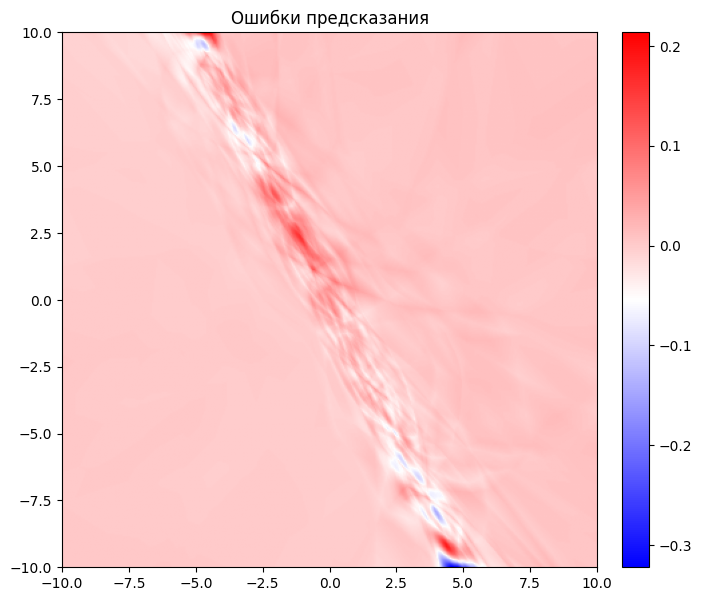

In [51]:
fig = plt.figure(figsize=(14, 6))

ax = fig.add_subplot(122)
im = ax.imshow(
    Z_pred - Z_true,
    extent=[x_vals.min(), x_vals.max(), y_vals.min(), y_vals.max()], # type: ignore
    origin='lower',
    cmap='bwr'
)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("Ошибки предсказания")

plt.tight_layout()
plt.show()